In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

In [2]:
import mlflow

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('nyc-expirement')

<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1752622411873, experiment_id='3', last_update_time=1752622411873, lifecycle_stage='active', name='nyc-expirement', tags={}>

In [3]:
df = pd.read_parquet('/home/youseef/MLOps-zoomcamp/data/green_tripdata_2023-01.parquet')
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.0590084265576

/tmp/ipykernel_43411/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_43411/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


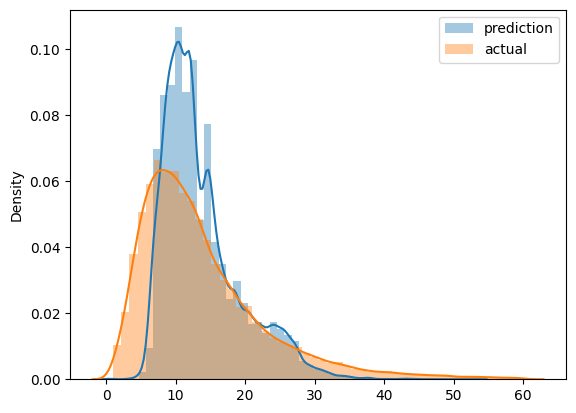

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-02.parquet')

In [8]:
len(df_train), len(df_val)

(73908, 61921)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715205807849

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
with mlflow.start_run():
    alpha = 0.01
    mlflow.set_tag("developer", 'YoussefMoamen')
    mlflow.log_param('train-data-path', '/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-01')
    mlflow.log_param('valid-data-path', '/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-02')
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse  = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

🏃 View run bedecked-panda-641 at: http://127.0.0.1:5000/#/experiments/3/runs/e031135dc2f741da9a080ab147b7cfbf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


In [15]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
mlflow.xgboost.autolog()
train = xgb.DMatrix(data=X_train, label=y_train)
valid = xgb.DMatrix(data=X_val, label=y_val)

In [17]:
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.set_tag('model', 'xgboost')
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=500,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha' : hp.loguniform('reg_alpha', -5, -1),
    'min_child_weight' : hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed' : 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()   
)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:41:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.65159                           
[1]	validation-rmse:8.22190                           
[2]	validation-rmse:7.45426                           
[3]	validation-rmse:7.05776                           
[4]	validation-rmse:6.84426                           
[5]	validation-rmse:6.72841                           
[6]	validation-rmse:6.65774                           
[7]	validation-rmse:6.61583                           
[8]	validation-rmse:6.58610                           
[9]	validation-rmse:6.56739                           
[10]	validation-rmse:6.55453                          
[11]	validation-rmse:6.54014                          
[12]	validation-rmse:6.53120                          
[13]	validation-rmse:6.52367                          
[14]	validation-rmse:6.51917                          
[15]	validation-rmse:6.51649                          
[16]	validation-rmse:6.51424                          
[17]	validation-rmse:6.50909                          
[18]	valid

2025/07/16 02:42:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:43:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:43:00] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run intelligent-mole-696 at: http://127.0.0.1:5000/#/experiments/3/runs/da53fc745be548a692719ec1c2efc354

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

  2%|▏         | 1/50 [01:17<1:03:29, 77.74s/trial, best loss: 6.446786037899296]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:43:16] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.10561                                                     
[1]	validation-rmse:10.19843                                                     
[2]	validation-rmse:9.46157                                                      
[3]	validation-rmse:8.87179                                                      
[4]	validation-rmse:8.40038                                                      
[5]	validation-rmse:8.02756                                                      
[6]	validation-rmse:7.73333                                                      
[7]	validation-rmse:7.49962                                                      
[8]	validation-rmse:7.31989                                                      
[9]	validation-rmse:7.17577                                                      
[10]	validation-rmse:7.06456                                                     
[11]	validation-rmse:6.97536                                                     
[12]	validation-

2025/07/16 02:44:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:44:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:44:02] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run trusting-donkey-820 at: http://127.0.0.1:5000/#/experiments/3/runs/77a1bccd6eff45ccb45bca304fe17145

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                     

  4%|▍         | 2/50 [02:26<57:44, 72.18s/trial, best loss: 6.426221710368355]  

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:44:24] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.74861                                                    
[1]	validation-rmse:8.33931                                                    
[2]	validation-rmse:7.56904                                                    
[3]	validation-rmse:7.15838                                                    
[4]	validation-rmse:6.93474                                                    
[5]	validation-rmse:6.81096                                                    
[6]	validation-rmse:6.73792                                                    
[7]	validation-rmse:6.69360                                                    
[8]	validation-rmse:6.66547                                                    
[9]	validation-rmse:6.64608                                                    
[10]	validation-rmse:6.63190                                                   
[11]	validation-rmse:6.62243                                                   
[12]	validation-rmse:6.61280            

2025/07/16 02:45:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:45:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:45:48] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run clumsy-elk-38 at: http://127.0.0.1:5000/#/experiments/3/runs/1f5060a4ff0343de9bcfe554903fd979

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

  6%|▌         | 3/50 [04:04<1:05:48, 84.01s/trial, best loss: 6.426221710368355]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:46:02] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.66423                                                     
[1]	validation-rmse:11.16338                                                     
[2]	validation-rmse:10.70661                                                     
[3]	validation-rmse:10.29161                                                     
[4]	validation-rmse:9.91472                                                      
[5]	validation-rmse:9.57356                                                      
[6]	validation-rmse:9.26459                                                      
[7]	validation-rmse:8.98574                                                      
[8]	validation-rmse:8.73438                                                      
[9]	validation-rmse:8.50780                                                      
[10]	validation-rmse:8.30457                                                     
[11]	validation-rmse:8.12152                                                     
[12]	validation-

2025/07/16 02:47:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:47:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:47:13] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run calm-bird-368 at: http://127.0.0.1:5000/#/experiments/3/runs/135b144ae8cb4454b922d8555b84563b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                     

  8%|▊         | 4/50 [05:31<1:05:27, 85.39s/trial, best loss: 6.4091852351589615]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:47:30] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.66130                                                      
[1]	validation-rmse:11.15793                                                      
[2]	validation-rmse:10.69747                                                      
[3]	validation-rmse:10.27929                                                      
[4]	validation-rmse:9.89831                                                       
[5]	validation-rmse:9.55322                                                       
[6]	validation-rmse:9.24136                                                       
[7]	validation-rmse:8.95976                                                       
[8]	validation-rmse:8.70631                                                       
[9]	validation-rmse:8.47687                                                       
[10]	validation-rmse:8.27166                                                      
[11]	validation-rmse:8.08646                                                      
[12]

2025/07/16 02:50:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:50:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:50:34] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run adaptable-shark-520 at: http://127.0.0.1:5000/#/experiments/3/runs/9086399afc0a42d496ada48c6a866db4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

 10%|█         | 5/50 [09:39<1:47:55, 143.90s/trial, best loss: 6.374618452192105]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:51:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.60719                                                      
[1]	validation-rmse:11.05964                                                      
[2]	validation-rmse:10.56524                                                      
[3]	validation-rmse:10.12072                                                      
[4]	validation-rmse:9.72163                                                       
[5]	validation-rmse:9.36424                                                       
[6]	validation-rmse:9.04499                                                       
[7]	validation-rmse:8.75945                                                       
[8]	validation-rmse:8.50566                                                       
[9]	validation-rmse:8.27993                                                       
[10]	validation-rmse:8.07908                                                      
[11]	validation-rmse:7.90092                                                      
[12]

2025/07/16 02:53:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:53:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:53:05] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run wistful-hen-86 at: http://127.0.0.1:5000/#/experiments/3/runs/27b63b4146b64fcc84cd988dbfb73f24

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

 12%|█▏        | 6/50 [11:28<1:36:46, 131.97s/trial, best loss: 6.374618452192105]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:53:29] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.07704                                                       
[1]	validation-rmse:6.77326                                                       
[2]	validation-rmse:6.74050                                                       
[3]	validation-rmse:6.72961                                                       
[4]	validation-rmse:6.71771                                                       
[5]	validation-rmse:6.71055                                                       
[6]	validation-rmse:6.70331                                                       
[7]	validation-rmse:6.69344                                                       
[8]	validation-rmse:6.68857                                                       
[9]	validation-rmse:6.68309                                                       
[10]	validation-rmse:6.67921                                                      
[11]	validation-rmse:6.67502                                                      
[12]

2025/07/16 02:54:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:54:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:54:04] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run funny-hare-231 at: http://127.0.0.1:5000/#/experiments/3/runs/028563f23f2540468cc41ce2e0d491a8

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

 14%|█▍        | 7/50 [12:33<1:18:53, 110.09s/trial, best loss: 6.320960614636599]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:54:32] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.84778                                                       
[1]	validation-rmse:8.41053                                                       
[2]	validation-rmse:7.59427                                                       
[3]	validation-rmse:7.13278                                                       
[4]	validation-rmse:6.88605                                                       
[5]	validation-rmse:6.74805                                                       
[6]	validation-rmse:6.65294                                                       
[7]	validation-rmse:6.59432                                                       
[8]	validation-rmse:6.56606                                                       
[9]	validation-rmse:6.53612                                                       
[10]	validation-rmse:6.51831                                                      
[11]	validation-rmse:6.50661                                                      
[12]

2025/07/16 02:55:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:55:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:55:43] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run magnificent-dove-606 at: http://127.0.0.1:5000/#/experiments/3/runs/5a01b627d6e947be8eda014464cac880

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

 16%|█▌        | 8/50 [14:46<1:22:16, 117.54s/trial, best loss: 6.320960614636599]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:56:46] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.69931                                                      
[1]	validation-rmse:9.56432                                                       
[2]	validation-rmse:8.72090                                                       
[3]	validation-rmse:8.11032                                                       
[4]	validation-rmse:7.66891                                                       
[5]	validation-rmse:7.35706                                                       
[6]	validation-rmse:7.13288                                                       
[7]	validation-rmse:6.97654                                                       
[8]	validation-rmse:6.85921                                                       
[9]	validation-rmse:6.77629                                                       
[10]	validation-rmse:6.71501                                                      
[11]	validation-rmse:6.66917                                                      
[12]

2025/07/16 02:57:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 02:57:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:57:51] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run auspicious-yak-937 at: http://127.0.0.1:5000/#/experiments/3/runs/f5b34f66c2d541eba752c79688519fae

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

 18%|█▊        | 9/50 [16:29<1:17:09, 112.91s/trial, best loss: 6.304929788901582]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:58:30] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.16281                                                      
[1]	validation-rmse:10.28965                                                      
[2]	validation-rmse:9.56613                                                       
[3]	validation-rmse:8.97495                                                       
[4]	validation-rmse:8.49205                                                       
[5]	validation-rmse:8.10321                                                       
[6]	validation-rmse:7.78589                                                       
[7]	validation-rmse:7.53326                                                       
[8]	validation-rmse:7.33210                                                       
[9]	validation-rmse:7.17023                                                       
[10]	validation-rmse:7.04169                                                      
[11]	validation-rmse:6.93986                                                      
[12]

2025/07/16 03:00:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:00:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:00:21] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run capable-rook-618 at: http://127.0.0.1:5000/#/experiments/3/runs/81fa64c39f55406fa627f076f375f055

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

[0]	validation-rmse:6.90532                                                       
 20%|██        | 10/50 [19:15<1:25:07, 127.68s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:01:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:6.74782                                                       
[2]	validation-rmse:6.72932                                                       
[3]	validation-rmse:6.71990                                                       
[4]	validation-rmse:6.70949                                                       
[5]	validation-rmse:6.70259                                                       
[6]	validation-rmse:6.69369                                                       
[7]	validation-rmse:6.69294                                                       
[8]	validation-rmse:6.69004                                                       
[9]	validation-rmse:6.68042                                                       
[10]	validation-rmse:6.67661                                                      
[11]	validation-rmse:6.67455                                                      
[12]	validation-rmse:6.66860                                                      
[13]

2025/07/16 03:01:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:01:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:01:54] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run polite-deer-365 at: http://127.0.0.1:5000/#/experiments/3/runs/04089e6177474cf0abf6674a8502af40

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

[0]	validation-rmse:9.12399                                                       
 22%|██▏       | 11/50 [20:39<1:14:14, 114.23s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:02:35] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.73173                                                       
[2]	validation-rmse:7.14147                                                       
[3]	validation-rmse:6.89536                                                       
[4]	validation-rmse:6.78474                                                       
[5]	validation-rmse:6.72408                                                       
[6]	validation-rmse:6.69385                                                       
[7]	validation-rmse:6.67279                                                       
[8]	validation-rmse:6.65615                                                       
[9]	validation-rmse:6.64846                                                       
[10]	validation-rmse:6.64157                                                      
[11]	validation-rmse:6.63376                                                      
[12]	validation-rmse:6.63100                                                      
[13]

2025/07/16 03:03:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:03:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:03:53] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run unruly-tern-781 at: http://127.0.0.1:5000/#/experiments/3/runs/3c120ea2c8da466d8e66eb3d96c55bde

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

[0]	validation-rmse:10.11415                                                      
 24%|██▍       | 12/50 [22:12<1:08:25, 108.05s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:04:08] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.78058                                                       
[2]	validation-rmse:7.96093                                                       
[3]	validation-rmse:7.46662                                                       
[4]	validation-rmse:7.17559                                                       
[5]	validation-rmse:7.00038                                                       
[6]	validation-rmse:6.89078                                                       
[7]	validation-rmse:6.82418                                                       
[8]	validation-rmse:6.78326                                                       
[9]	validation-rmse:6.75656                                                       
[10]	validation-rmse:6.73825                                                      
[11]	validation-rmse:6.72214                                                      
[12]	validation-rmse:6.71337                                                      
[13]

2025/07/16 03:04:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:04:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:04:49] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run defiant-robin-662 at: http://127.0.0.1:5000/#/experiments/3/runs/5fcb640f2acd440cad5410c6b13b7641

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                      

 26%|██▌       | 13/50 [23:06<57:29, 93.23s/trial, best loss: 6.29466300866444]   

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:05:06] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.35659                                                    
[1]	validation-rmse:7.88770                                                    
[2]	validation-rmse:7.17851                                                    
[3]	validation-rmse:6.84578                                                    
[4]	validation-rmse:6.67981                                                    
[5]	validation-rmse:6.59391                                                    
[6]	validation-rmse:6.54764                                                    
[7]	validation-rmse:6.51949                                                    
[8]	validation-rmse:6.49721                                                    
[9]	validation-rmse:6.48114                                                    
[10]	validation-rmse:6.47180                                                   
[11]	validation-rmse:6.46347                                                   
[12]	validation-rmse:6.45803            

2025/07/16 03:05:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:05:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:05:51] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run handsome-doe-332 at: http://127.0.0.1:5000/#/experiments/3/runs/c042991c2639438d926f38562f8c0270

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

 28%|██▊       | 14/50 [24:19<52:13, 87.04s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:06:21] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.47311                                                   
[1]	validation-rmse:9.24677                                                    
[2]	validation-rmse:8.40153                                                    
[3]	validation-rmse:7.83012                                                    
[4]	validation-rmse:7.44707                                                    
[5]	validation-rmse:7.19276                                                    
[6]	validation-rmse:7.02463                                                    
[7]	validation-rmse:6.91116                                                    
[8]	validation-rmse:6.83295                                                    
[9]	validation-rmse:6.77890                                                    
[10]	validation-rmse:6.74141                                                   
[11]	validation-rmse:6.71358                                                   
[12]	validation-rmse:6.69386            

2025/07/16 03:07:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:07:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:07:13] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run delightful-shrimp-71 at: http://127.0.0.1:5000/#/experiments/3/runs/6808f93a903b4c129bdd0d5103fcd3fa

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

 30%|███       | 15/50 [25:37<49:12, 84.35s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:07:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.69461                                                   
[1]	validation-rmse:11.21960                                                   
[2]	validation-rmse:10.78494                                                   
[3]	validation-rmse:10.38815                                                   
[4]	validation-rmse:10.02637                                                   
[5]	validation-rmse:9.69706                                                    
[6]	validation-rmse:9.39755                                                    
[7]	validation-rmse:9.12606                                                    
[8]	validation-rmse:8.88032                                                    
[9]	validation-rmse:8.65757                                                    
[10]	validation-rmse:8.45600                                                   
[11]	validation-rmse:8.27452                                                   
[12]	validation-rmse:8.11021            

2025/07/16 03:09:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:09:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:09:51] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run rogue-snipe-389 at: http://127.0.0.1:5000/#/experiments/3/runs/735c306945d74cc388c323218cc39f65

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

 32%|███▏      | 16/50 [28:07<58:54, 103.94s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:10:09] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.75132                                                     
[1]	validation-rmse:6.63218                                                     
[2]	validation-rmse:6.60519                                                     
[3]	validation-rmse:6.59185                                                     
[4]	validation-rmse:6.56753                                                     
[5]	validation-rmse:6.56058                                                     
[6]	validation-rmse:6.55450                                                     
[7]	validation-rmse:6.54828                                                     
[8]	validation-rmse:6.54277                                                     
[9]	validation-rmse:6.53905                                                     
[10]	validation-rmse:6.53720                                                    
[11]	validation-rmse:6.53523                                                    
[12]	validation-rmse:6.53282

2025/07/16 03:10:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:10:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:10:30] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run painted-dog-786 at: http://127.0.0.1:5000/#/experiments/3/runs/76723e7c5b8244739b293347c06e7165

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                    

 34%|███▍      | 17/50 [28:45<46:18, 84.19s/trial, best loss: 6.29466300866444] 

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:10:47] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.43658                                                   
[1]	validation-rmse:9.19336                                                    
[2]	validation-rmse:8.34227                                                    
[3]	validation-rmse:7.77159                                                    
[4]	validation-rmse:7.39405                                                    
[5]	validation-rmse:7.14433                                                    
[6]	validation-rmse:6.97707                                                    
[7]	validation-rmse:6.86268                                                    
[8]	validation-rmse:6.78737                                                    
[9]	validation-rmse:6.73123                                                    
[10]	validation-rmse:6.69242                                                   
[11]	validation-rmse:6.66509                                                   
[12]	validation-rmse:6.64439            

2025/07/16 03:11:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:11:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:11:56] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run brawny-foal-555 at: http://127.0.0.1:5000/#/experiments/3/runs/d023b01d55924725ac2db1748e749628

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

[0]	validation-rmse:10.10564                                                   
 36%|███▌      | 18/50 [30:18<45:25, 85.16s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:12:14] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.76034                                                    
[2]	validation-rmse:7.93228                                                    
[3]	validation-rmse:7.43440                                                    
[4]	validation-rmse:7.13827                                                    
[5]	validation-rmse:6.96169                                                    
[6]	validation-rmse:6.85139                                                    
[7]	validation-rmse:6.78247                                                    
[8]	validation-rmse:6.73770                                                    
[9]	validation-rmse:6.70826                                                    
[10]	validation-rmse:6.68867                                                   
[11]	validation-rmse:6.67367                                                   
[12]	validation-rmse:6.66345                                                   
[13]	validation-rmse:6.65492            

2025/07/16 03:12:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:12:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:12:49] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run judicious-turtle-139 at: http://127.0.0.1:5000/#/experiments/3/runs/e2395c141d8d42ee822cb1321e8245c3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

 38%|███▊      | 19/50 [31:03<38:42, 74.92s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:13:06] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.71202                                                   
[1]	validation-rmse:11.25191                                                   
[2]	validation-rmse:10.82978                                                   
[3]	validation-rmse:10.44338                                                   
[4]	validation-rmse:10.09018                                                   
[5]	validation-rmse:9.76714                                                    
[6]	validation-rmse:9.47378                                                    
[7]	validation-rmse:9.20641                                                    
[8]	validation-rmse:8.96295                                                    
[9]	validation-rmse:8.74250                                                    
[10]	validation-rmse:8.54235                                                   
[11]	validation-rmse:8.36131                                                   
[12]	validation-rmse:8.19721            

2025/07/16 03:13:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:13:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:13:44] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run welcoming-shark-607 at: http://127.0.0.1:5000/#/experiments/3/runs/95952f2a3a2643ae8997d79c9a1ca810

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

 40%|████      | 20/50 [31:59<34:30, 69.01s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:14:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.01793                                                   
[1]	validation-rmse:10.05606                                                   
[2]	validation-rmse:9.28830                                                    
[3]	validation-rmse:8.68126                                                    
[4]	validation-rmse:8.20397                                                    
[5]	validation-rmse:7.83427                                                    
[6]	validation-rmse:7.55091                                                    
[7]	validation-rmse:7.32967                                                    
[8]	validation-rmse:7.16018                                                    
[9]	validation-rmse:7.02909                                                    
[10]	validation-rmse:6.92693                                                   
[11]	validation-rmse:6.84461                                                   
[12]	validation-rmse:6.78288            

2025/07/16 03:15:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:15:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:15:01] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run delightful-trout-365 at: http://127.0.0.1:5000/#/experiments/3/runs/c48afefe41c14d6c800197b5389dbfbc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

 42%|████▏     | 21/50 [33:39<37:57, 78.53s/trial, best loss: 6.29466300866444]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [03:15:46] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.27341                                                   
[1]	validation-rmse:10.47618                                                   
[2]	validation-rmse:9.80376                                                    
[3]	validation-rmse:9.23906                                                    
[4]	validation-rmse:8.76832                                                    
[5]	validation-rmse:8.38035                                                    
[6]	validation-rmse:8.05942                                                    
[7]	validation-rmse:7.79532                                                    
[8]	validation-rmse:7.58095                                                    
[9]	validation-rmse:7.40230                                                    
[10]	validation-rmse:7.25880                                                   
[11]	validation-rmse:7.13913                                                   
[12]	validation-rmse:7.04278            

2025/07/16 03:17:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/16 03:17:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [03:17:12] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



🏃 View run powerful-snipe-633 at: http://127.0.0.1:5000/#/experiments/3/runs/979d96d01d7f4e1dac4f53a01e168c46

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3                   

 44%|████▍     | 22/50 [35:52<44:10, 94.65s/trial, best loss: 6.29466300866444]